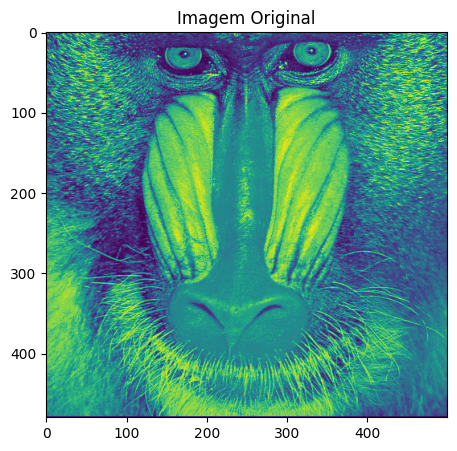

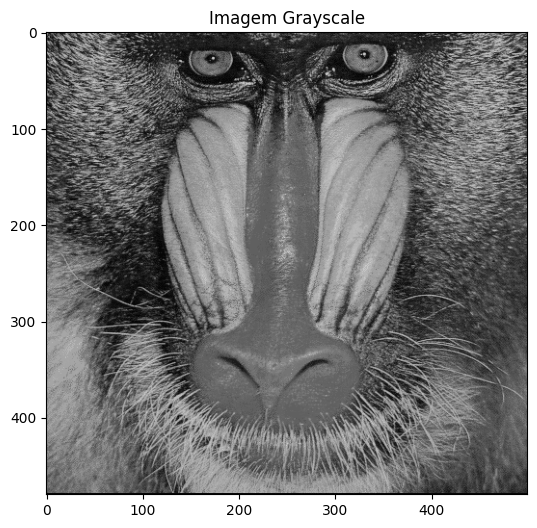

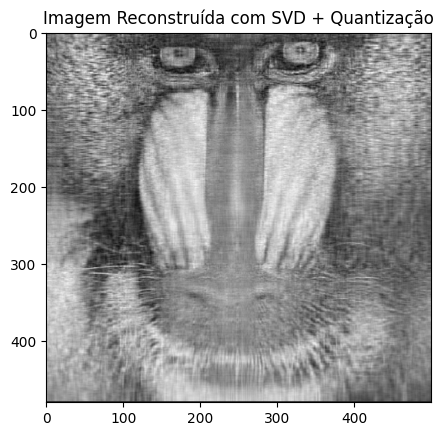

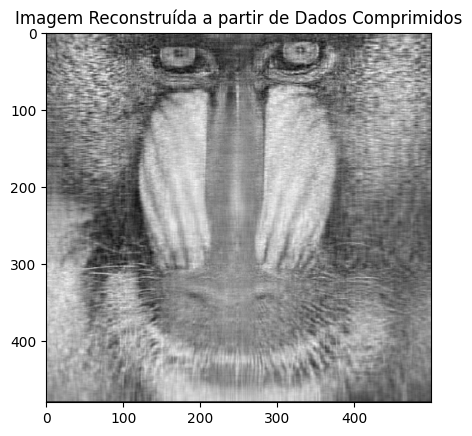

Taxa de Compressão: 8.15


ValueError: operands could not be broadcast together with shapes (480,500,2) (480,500) 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pickle  # Usado para salvar objetos binários no disco

# Carregar a imagem original
img = Image.open('./baboon.pgm')
plt.figure(figsize=(9,5))
plt.imshow(img)
plt.title("Imagem Original")
plt.show()

# Converter a imagem para grayscale (somente luminância)
imggray = img.convert('L')  # 'L' para imagem em escala de cinza
plt.figure(figsize=(9,6))
plt.imshow(imggray, cmap='gray')
plt.title("Imagem Grayscale")
plt.show()

# Converter a imagem para uma matriz numpy (apenas o canal de luminância)
original_img = np.array(imggray)

# Converter para matriz de imagem para a decomposição SVD
imgmat = np.array(list(imggray.getdata()), float)
imgmat.shape = (imggray.size[1], imggray.size[0])
imgmat = np.matrix(imgmat)

# Decomposição SVD
U, sigma, V = np.linalg.svd(imgmat)

# Quantização: escolher o número de níveis para quantização
quantization_levels = 120  # O número de níveis para quantização (ajuste conforme necessário)

# Função de quantização
def quantize(sigma, levels):
    min_val, max_val = sigma.min(), sigma.max()
    step = (max_val - min_val) / (levels - 1)
    
    # Quantizando os valores de sigma
    quantized_sigma = np.round((sigma - min_val) / step) * step + min_val
    return quantized_sigma

# Quantizando os coeficientes sigma
quantized_sigma = quantize(sigma, quantization_levels)

# Número de termos a ser usado na reconstrução
term_number = 30  # O número de termos a ser usado na reconstrução (ajuste conforme necessário)

# Reconstituir a imagem com coeficientes quantizados
reconstimg = np.matrix(U[:, :term_number]) * np.diag(quantized_sigma[:term_number]) * np.matrix(V[:term_number, :])

# Exibir a imagem reconstruída com SVD + Quantização
plt.imshow(reconstimg, cmap='gray')
plt.title("Imagem Reconstruída com SVD + Quantização")
plt.show()

# Passo 1: Salvar os dados comprimidos em arquivos binários
def save_compressed_data(U, sigma, V, term_number, filename="compressed_data.pkl"):
    U_reduced = U[:, :term_number]
    sigma_reduced = sigma[:term_number]
    V_reduced = V[:term_number, :]
    with open(filename, 'wb') as f:
        pickle.dump((U_reduced, sigma_reduced, V_reduced), f)

# Passo 2: Carregar os dados comprimidos de arquivos binários
def load_compressed_data(filename="compressed_data.pkl"):
    with open(filename, 'rb') as f:
        U_reduced, sigma_reduced, V_reduced = pickle.load(f)
    return U_reduced, sigma_reduced, V_reduced

# Salvar os dados comprimidos
save_compressed_data(U, quantized_sigma, V, term_number)

# Passo 3: Decodificar os dados e reconstruir a imagem
U_loaded, sigma_loaded, V_loaded = load_compressed_data()

# Reconstituir a imagem a partir dos dados carregados
reconstimg_loaded = np.matrix(U_loaded) * np.diag(sigma_loaded) * np.matrix(V_loaded)

# Exibir a imagem reconstruída a partir dos dados carregados
plt.imshow(reconstimg_loaded, cmap='gray')
plt.title("Imagem Reconstruída a partir de Dados Comprimidos")
plt.show()

# Cálculo da Taxa de Compressão
def compression_rate(original_img, compressed_data_filename):
    # Tamanho original da imagem
    original_size = original_img.size[0] * original_img.size[1] * 8  # 8 bits por pixel (para imagem grayscale)
    
    # Tamanho comprimido (em bytes)
    with open(compressed_data_filename, 'rb') as f:
        compressed_size = len(f.read())
    
    # Taxa de compressão
    return original_size / compressed_size

# Função para calcular o PSNR
def psnr(original_img, reconstructed_img):
    # Calcular o erro quadrático médio (MSE)
    mse = np.mean((original_img - reconstructed_img) ** 2)
    
    # Valor máximo para a imagem (255 para imagens 8-bits)
    max_pixel = 255.0
    
    # Calcular PSNR
    return 10 * np.log10((max_pixel ** 2) / mse)

# Calcular a taxa de compressão
rate = compression_rate(imggray, "compressed_data.pkl")
print(f"Taxa de Compressão: {rate:.2f}")

# Calcular o PSNR
reconstructed_img = np.array(reconstimg_loaded)

psnr_value = psnr(original_img, reconstructed_img)
print(f"PSNR: {psnr_value:.2f} dB")
